In [1]:
import meep as mp
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

In [2]:
from matplotlib.colors import LinearSegmentedColormap

# Increase the default resolution for images
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Use dark background
plt.style.use('dark_background')

# Custom colormaps
cmap_alpha = LinearSegmentedColormap.from_list('custom_alpha',[[1,1,1,0],[1,1,1,1]])

cmap_blue = LinearSegmentedColormap.from_list('custom_blue', [[0,0,0],[0,0.66,1],[1,1,1]])

def label_plot(ax, title = None, xlabel = None, ylabel = None, elapsed = None):
    """Add title and axis labels to the plot.

    Args:
        ax (_type_): _description_
        title (_type_, optional): _description_. Defaults to None.
        xlabel (_type_, optional): _description_. Defaults to None.
        ylabel (_type_, optional): _description_. Defaults to None.
        elapsed (_type_, optional): _description_. Defaults to None.
    """
    if title:
        ax.set_title(title)
    elif elapsed is not None:
        ax.set_title(f'{elapsed:0.1f} fs')
    if xlabel is not False:
        ax.set_xlabel('x ($\mu$m)' if xlabel is None else xlabel)
    if ylabel is not False:
        ax.set_ylabel('y ($\mu$m)' if ylabel is None else ylabel)

def plot_eps_data(eps_data, domain, ax=None, **kwargs):
    """Plot wall geometry within the domain

    Args:
        eps_data (_type_): _description_
        domain (_type_): _description_
        ax (_type_, optional): _description_. Defaults to None.
    """
    ax = ax or plt.gca()
    ax.imshow(eps_data.T, cmap = cmap_alpha, extent = domain, origin = 'lower')
    label_plot(ax, **kwargs)

def plot_ez_data(ez_data, domain, ax = None, vmax = None, aspect = None, **kwargs):
    """ Plot amplitude of complex valued electric field.

    Args:
        ez_data (_type_): _description_
        domain (_type_): _description_
        ax (_type_, optional): _description_. Defaults to None.
        vmax (_type_, optional): _description_. Defaults to None.
        aspect (_type_, optional): _description_. Defaults to None.
    """
    ax = ax or plt.gca()
    ax.imshow(
        np.abs(ez_data.T),
        interpolation='spline36',
        cmap = cmap_blue,
        extent=domain,
        vmax = vmax,
        aspect=aspect,
        origin='lower'
    )
    label_plot(ax,**kwargs)

def plot_pml(pml_thickness, domain, ax = None):
    
    ax = ax or plt.gca()
    x_start = domain[0] + pml_thickness
    x_end = domain[1] - pml_thickness
    y_start = domain[2] + pml_thickness
    y_end = domain[3] - pml_thickness
    rect = plt.Rectangle(
        (x_start, y_start),
        x_end - x_start,
        y_end - y_start,
        fill = None,
        color = '#fff',
        linestyle = 'dashed'
    )
    ax.add_patch(rect)

In [3]:
# speed of light
SOL = 0.299792458

# 2D spatial domain measured in micrometers
domain = [0, 30, -10, 10]

center = mp.Vector3(
    (domain[1] + domain[0])/2,
    (domain[3] + domain[2])/2
)

cell_size = mp.Vector3(
    domain[1] - domain[0],
    domain[3] - domain[2]
)

In [4]:
# Dimensions of wall with two apertures
wall_position = 10
wall_thickness = 0.5
aperture_width = 1
inner_wall_len = 4
outer_wall_len = (
    cell_size[1]
    - 2*aperture_width
    - inner_wall_len
)/2

# Define wall with high dielectric constant
material = mp.Medium(epsilon = 1e6)

# Define the wall as an array of 3 blocks arranged vertically
geometry = [
    mp.Block(
        mp.Vector3(wall_thickness, outer_wall_len, mp.inf),
        center = mp.Vector3(
            wall_position - center.x,
            domain[3] - outer_wall_len/2
        ),
        material = material
    ),
    mp.Block(
        mp.Vector3(wall_thickness, outer_wall_len, mp.inf),
        center = mp.Vector3(
            wall_position - center.x,
            domain[2] + outer_wall_len/2
        ),
        material = material
    ),
    mp.Block(
        mp.Vector3(wall_thickness, inner_wall_len, mp.inf),
        center = mp.Vector3(
            wall_position - center.x,
            0
        ),
        material = material
    )
]

# Perfectly matched layer
pml_thickness = 1
pml_layers = [mp.PML(pml_thickness)]

-----------
Initializing structure...
time for choose_chunkdivision = 0.000657082 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 10
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.103579 s
-----------


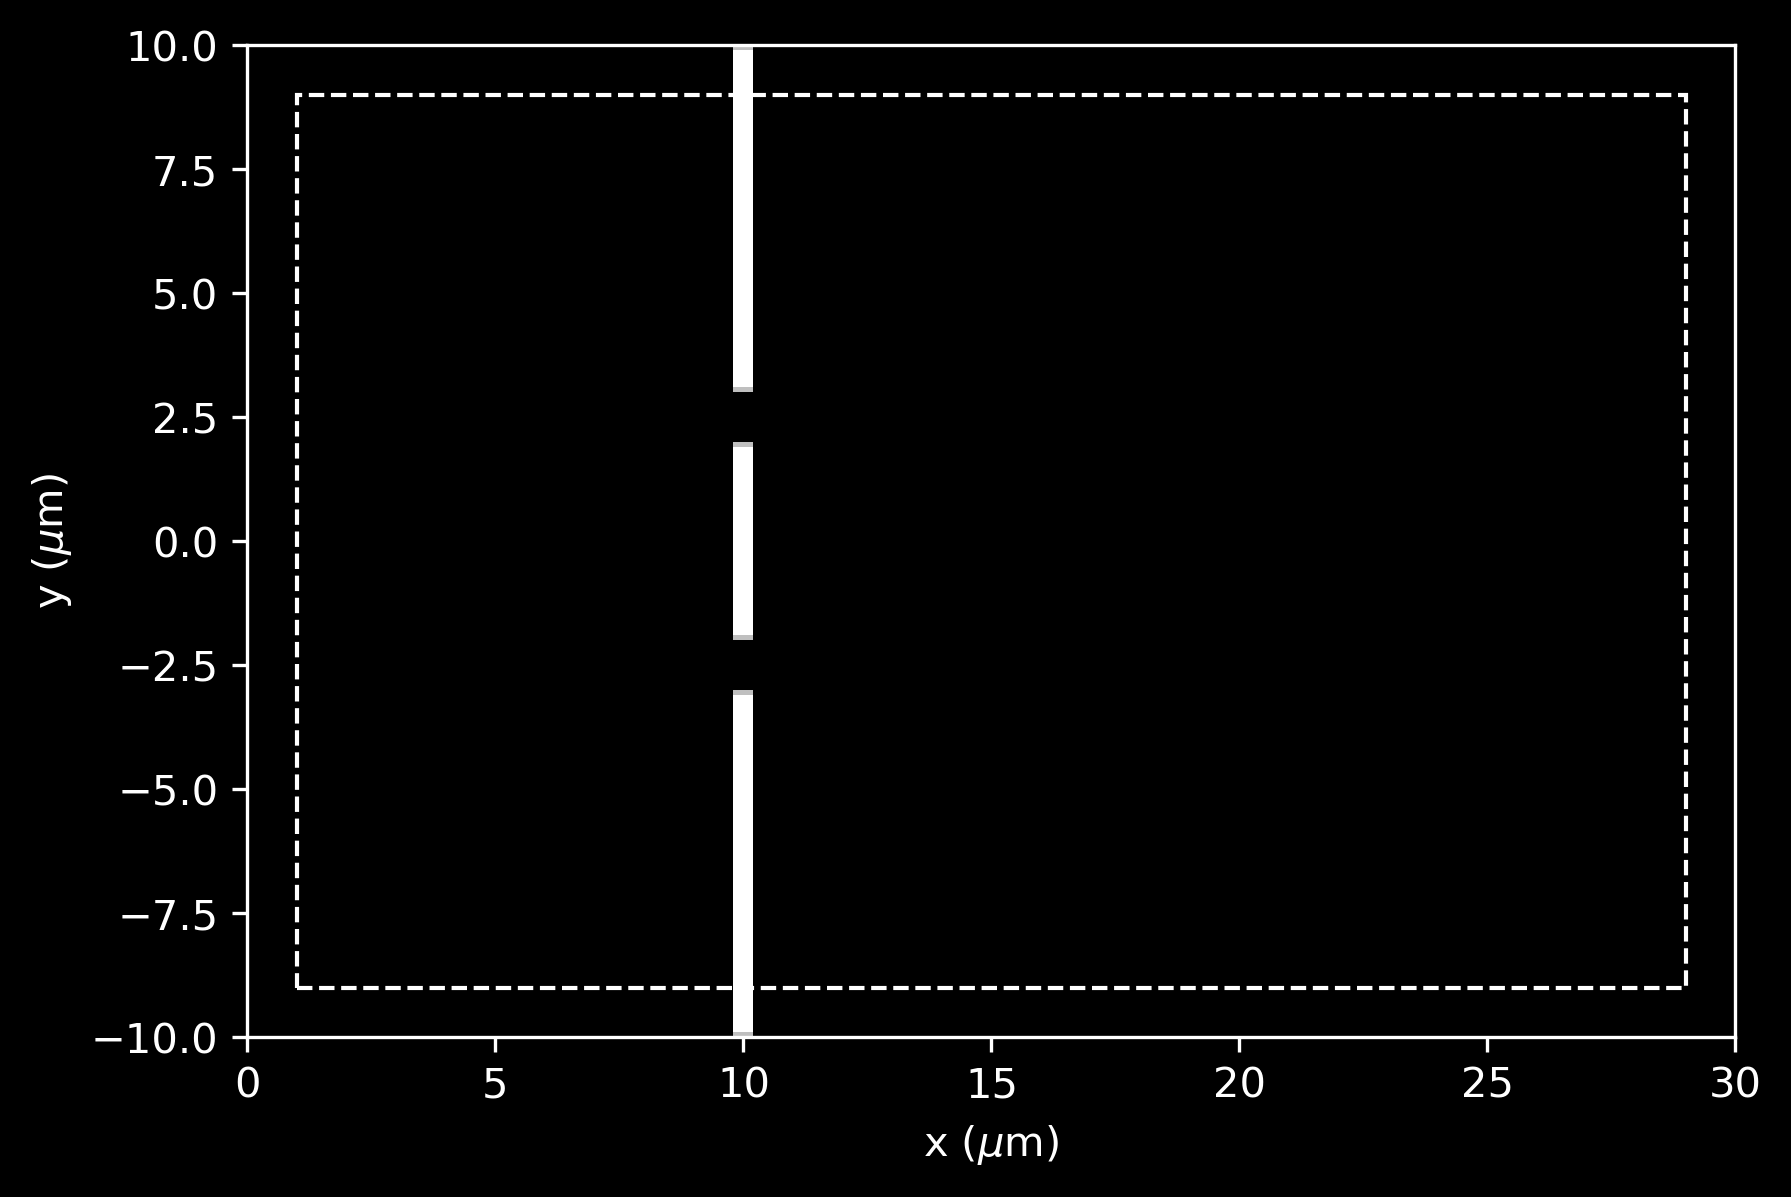

In [5]:
resolution = 10

# Visualize dielectric data
sim = mp.Simulation(cell_size=cell_size, geometry=geometry, resolution = resolution)
sim.init_sim()
eps_data = sim.get_array(center = mp.Vector3(), size = cell_size, component = mp.Dielectric)

ax = plt.gca()

plot_pml(pml_thickness, domain, ax = ax)
plot_eps_data(eps_data, domain, ax = ax)

In [6]:
# Light source
source_lambda = 0.47
source_frequency = 1/ source_lambda
source_beam_width = 6

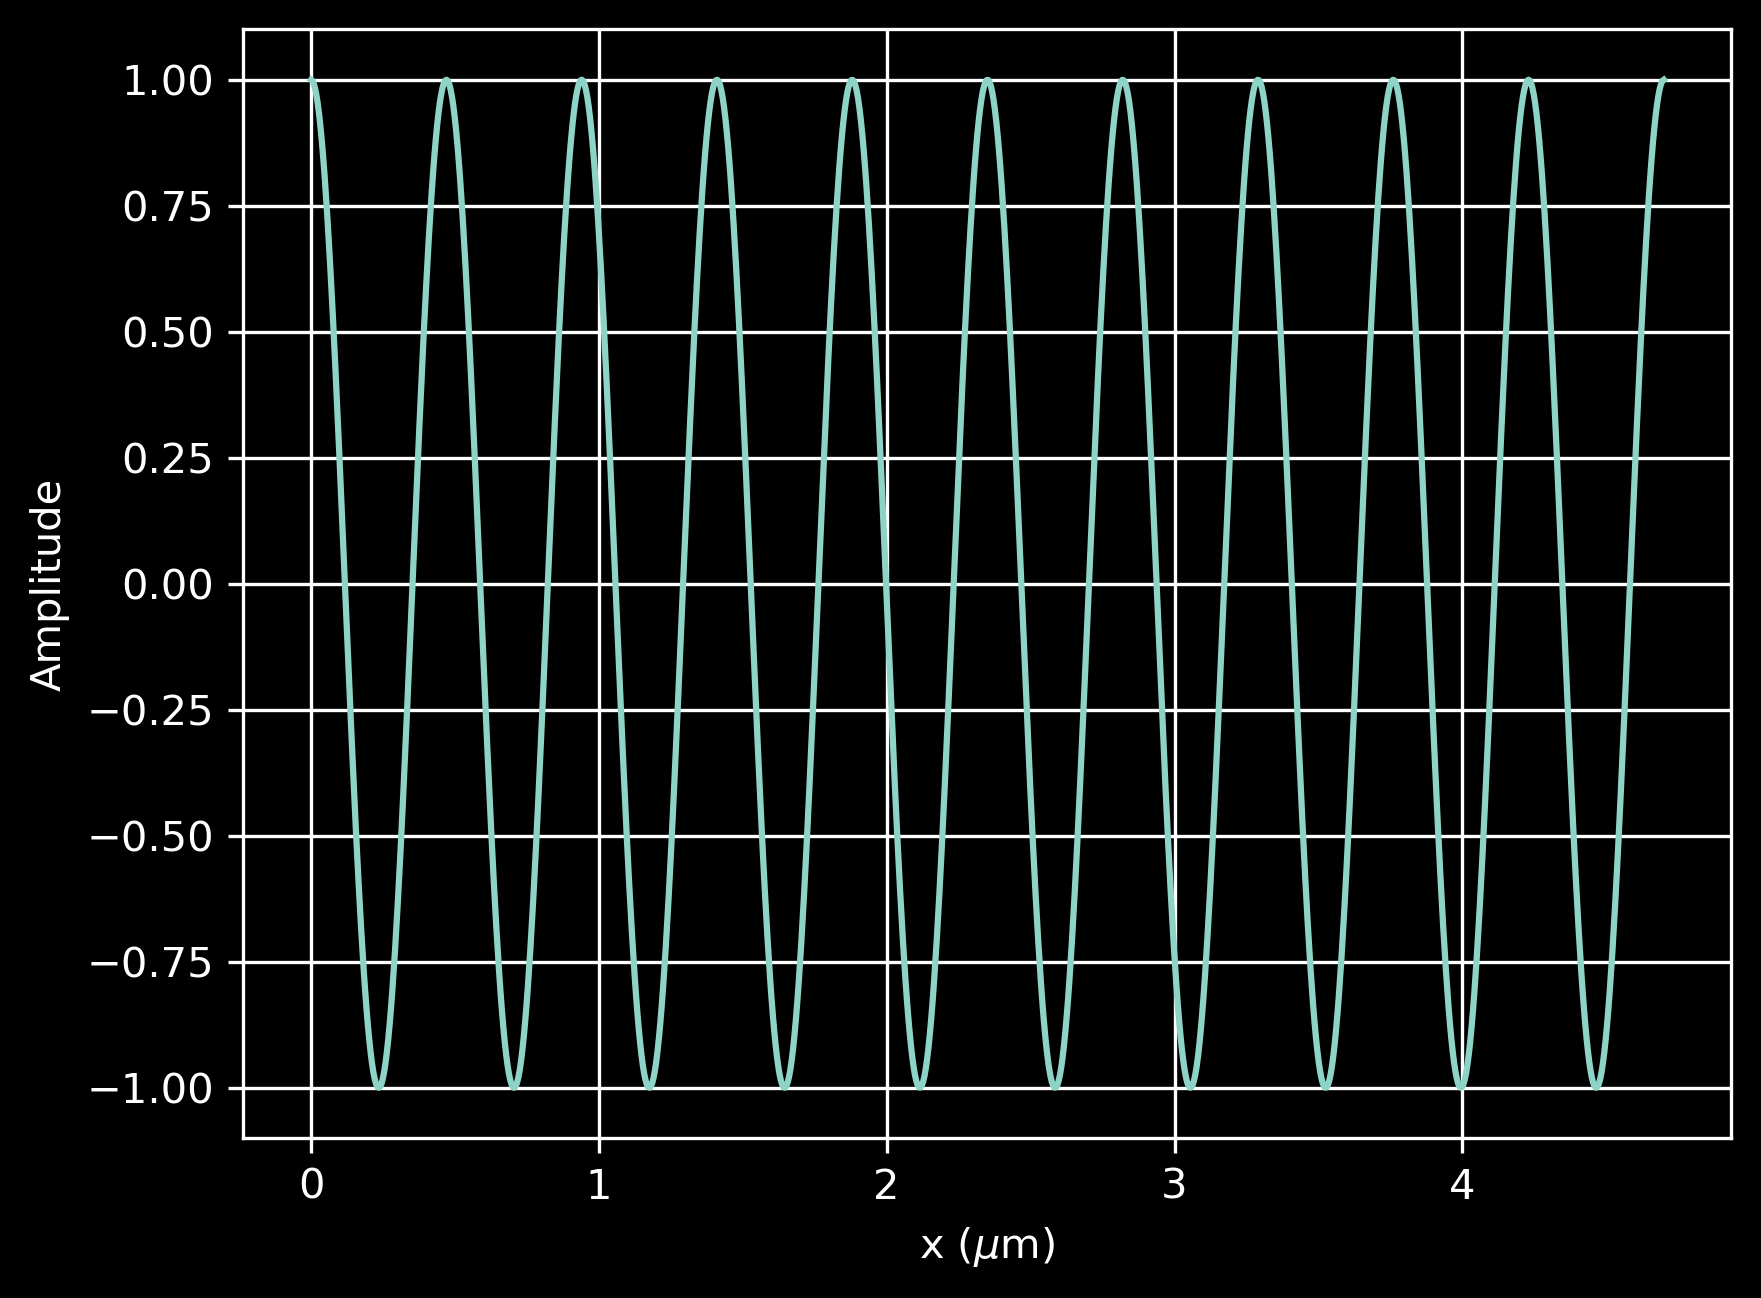

In [7]:
# Create plane wave in x-direction

def plane_wave(x):
    return np.exp(2j * np.pi/source_lambda*x)

# Plot plane wave

xarr = np.linspace(0, 10*source_lambda, 1000)
wave = plane_wave(xarr)
plt.plot(xarr, wave.real)
plt.xlabel('x ($\mu$m)')
plt.ylabel('Amplitude')
plt.grid(True)

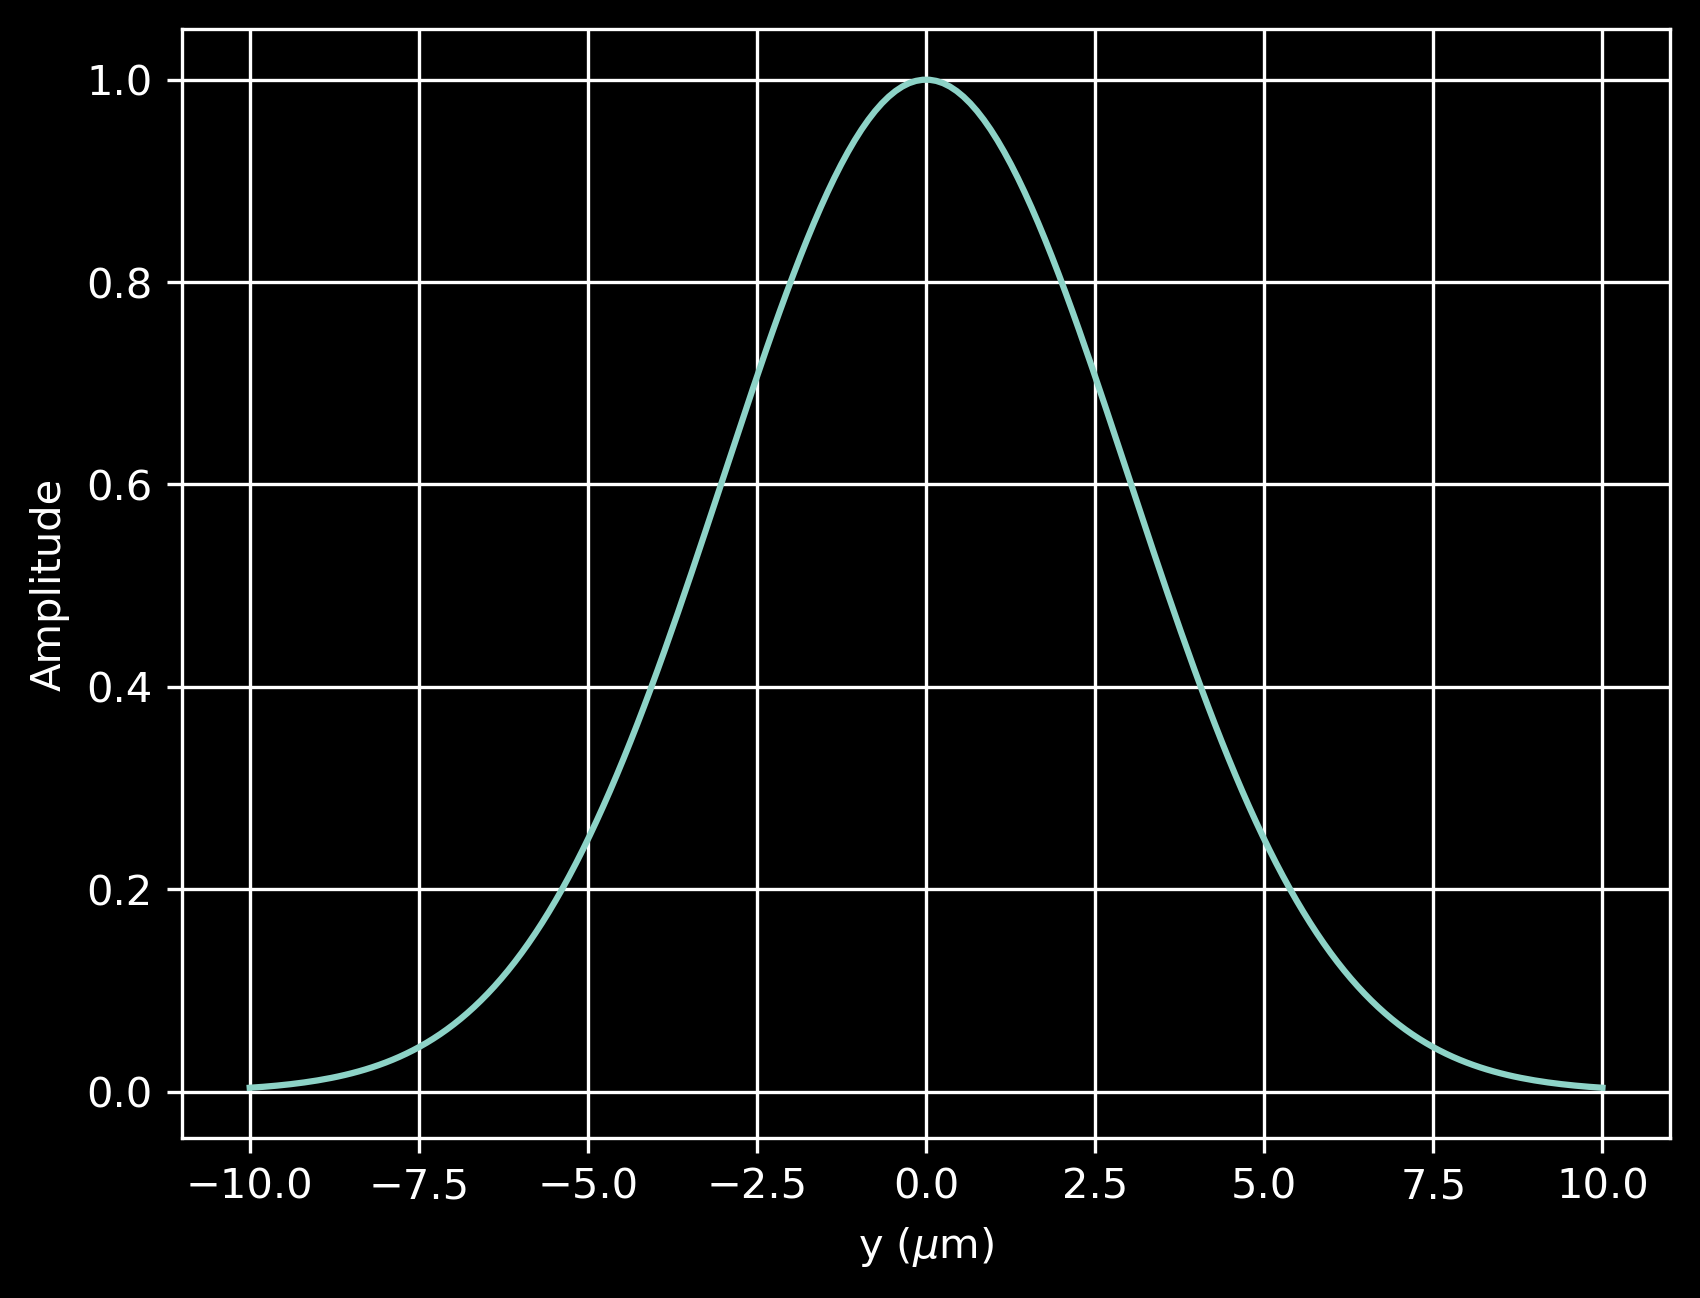

In [8]:
# compute gaussian profile in the y-direction
def gaussian_profile(y):
    return np.exp(-y**2/(2*(source_beam_width/2)**2))

# Plot Gaussian profile
yarr = np.linspace(domain[2], domain[3], 200)
prof = gaussian_profile(yarr)
plt.plot(yarr, prof)
plt.xlabel('y ($\mu$m)')
plt.ylabel('Amplitude')
plt.grid(True)

Text(0, 0.5, 'y ($\\mu$m)')

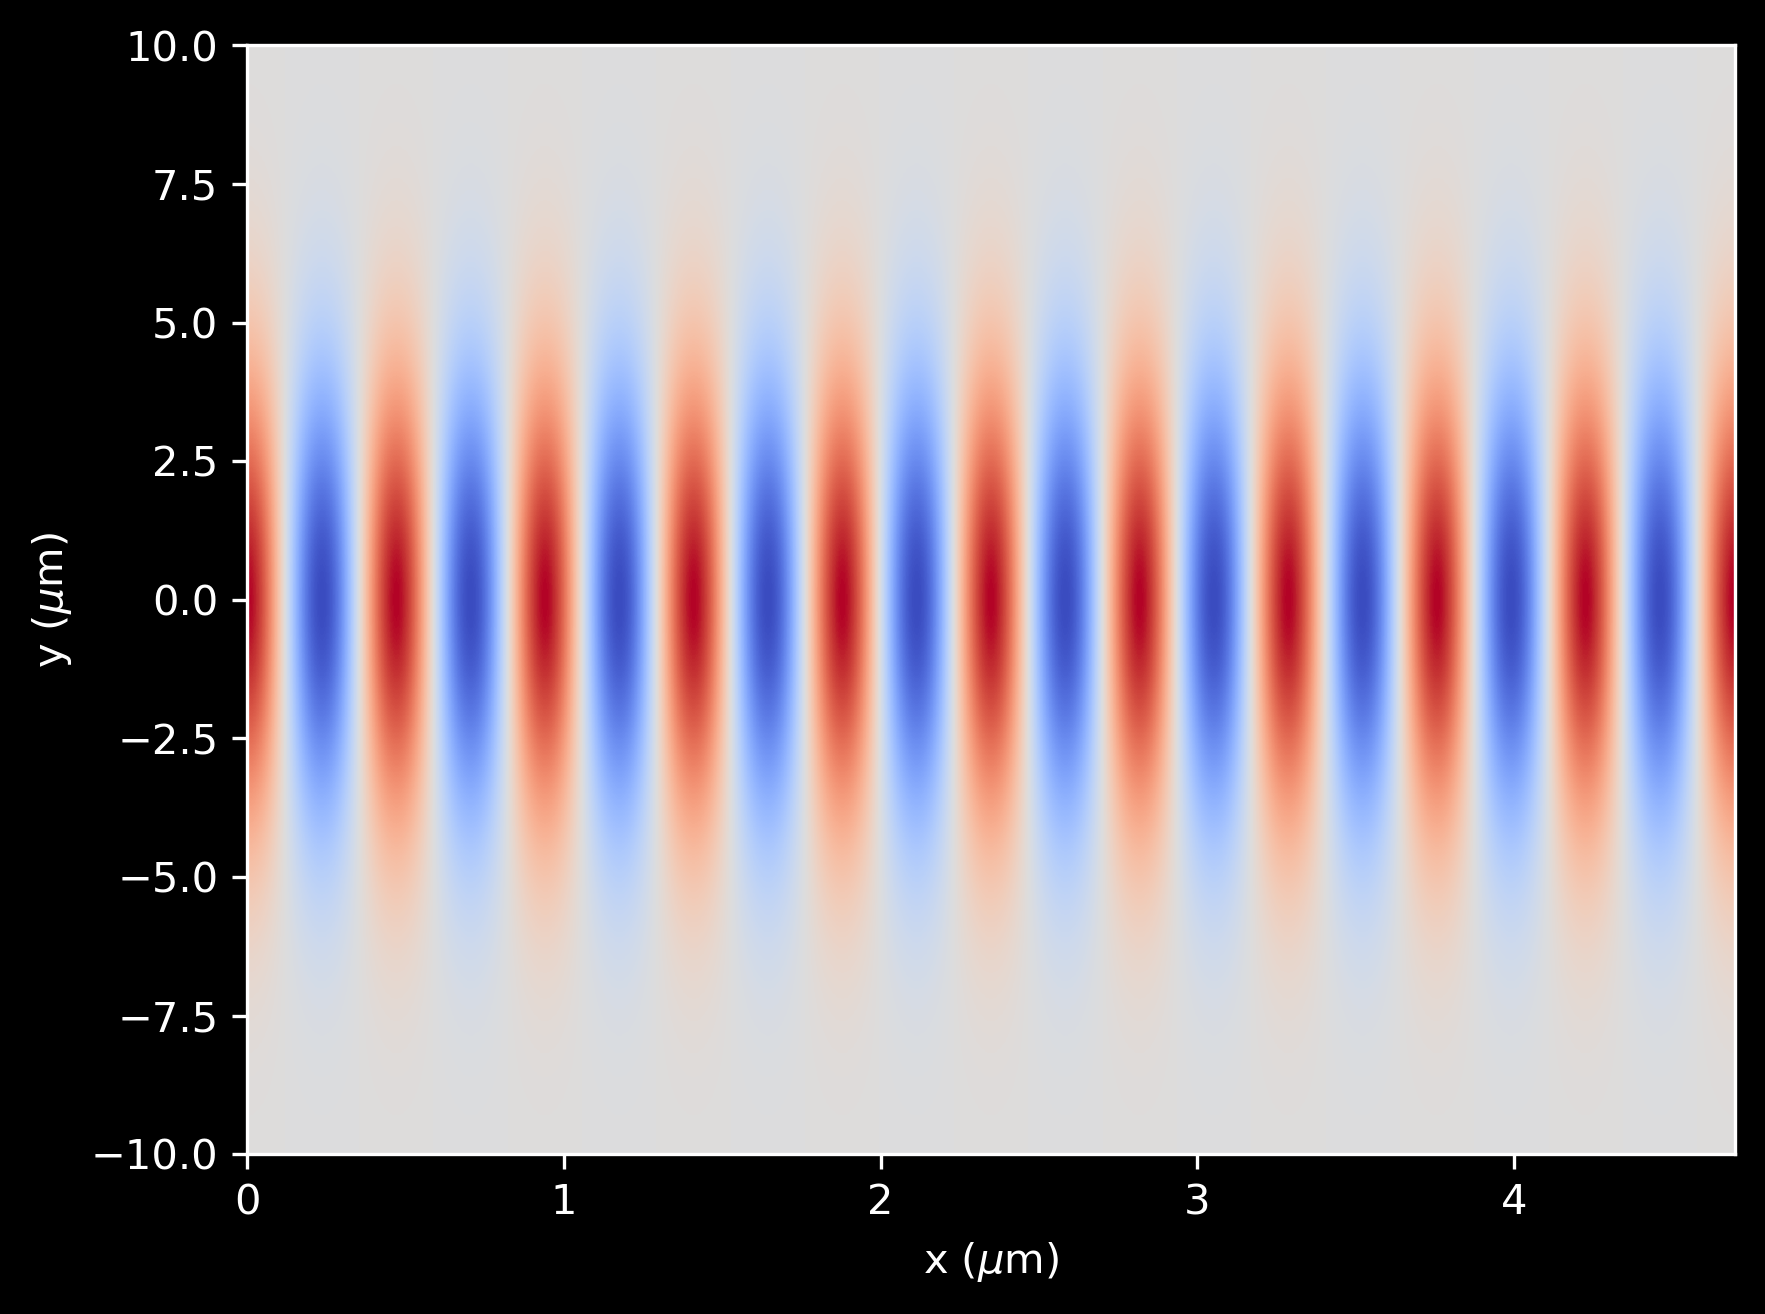

In [9]:
# 2D grid

X, Y = np.meshgrid(xarr, yarr)

combined = plane_wave(X) * gaussian_profile(Y)

plt.imshow(
    np.real(combined),
    cmap = 'coolwarm',
    aspect = 'auto',
    extent = [xarr[0], xarr[-1], yarr[0], yarr[-1]],
    origin = 'lower'
)

plt.xlabel('x ($\mu$m)')
plt.ylabel('y ($\mu$m)')

In [10]:
def amp_func(pos):
    return plane_wave(pos[0]) * gaussian_profile(pos[1])

source = mp.Source(
    src = mp.ContinuousSource(
        frequency=source_frequency,
        is_integrated=True
    ),
    component=mp.Ez,
    center = mp.Vector3(1,0,0) - center,
    size = mp.Vector3(y = cell_size[1]),
    amp_func=amp_func
)

In [11]:
smallest_length = min(
    source_lambda,
    wall_thickness,
    aperture_width,
    inner_wall_len
)
pixel_count = 10
resolution = int(np.ceil(pixel_count/smallest_length))
print('Simulation resolution:', resolution)

Simulation resolution: 22


-----------
Initializing structure...
time for choose_chunkdivision = 0.000918865 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 22
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.584591 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=40.0)

Meep progress: 8.113636363636363/40.0 = 20.3% done in 4.0s, 15.7s to go
on time step 358 (time=8.13636), 0.0111869 s/step
Meep progress: 16.772727272727273/40.0 = 41.9% done in 8.0s, 11.1s to go
on time step 739 (time=16.7955), 0.0105158 s/step
Meep progress: 26.636363636363637/40.0 = 66.6% done in 12.0s, 6.0s to go
on time step 1173 (time=26.6591), 0.00922439 s/step
Meep progress: 38.20454545454545/40.0 = 95.5% done in 16.0s, 0.8s to go
on time step 1682 (time=38.2273), 0.00786726 s/step
run 0 finished at t = 40.0 (1760 timesteps)


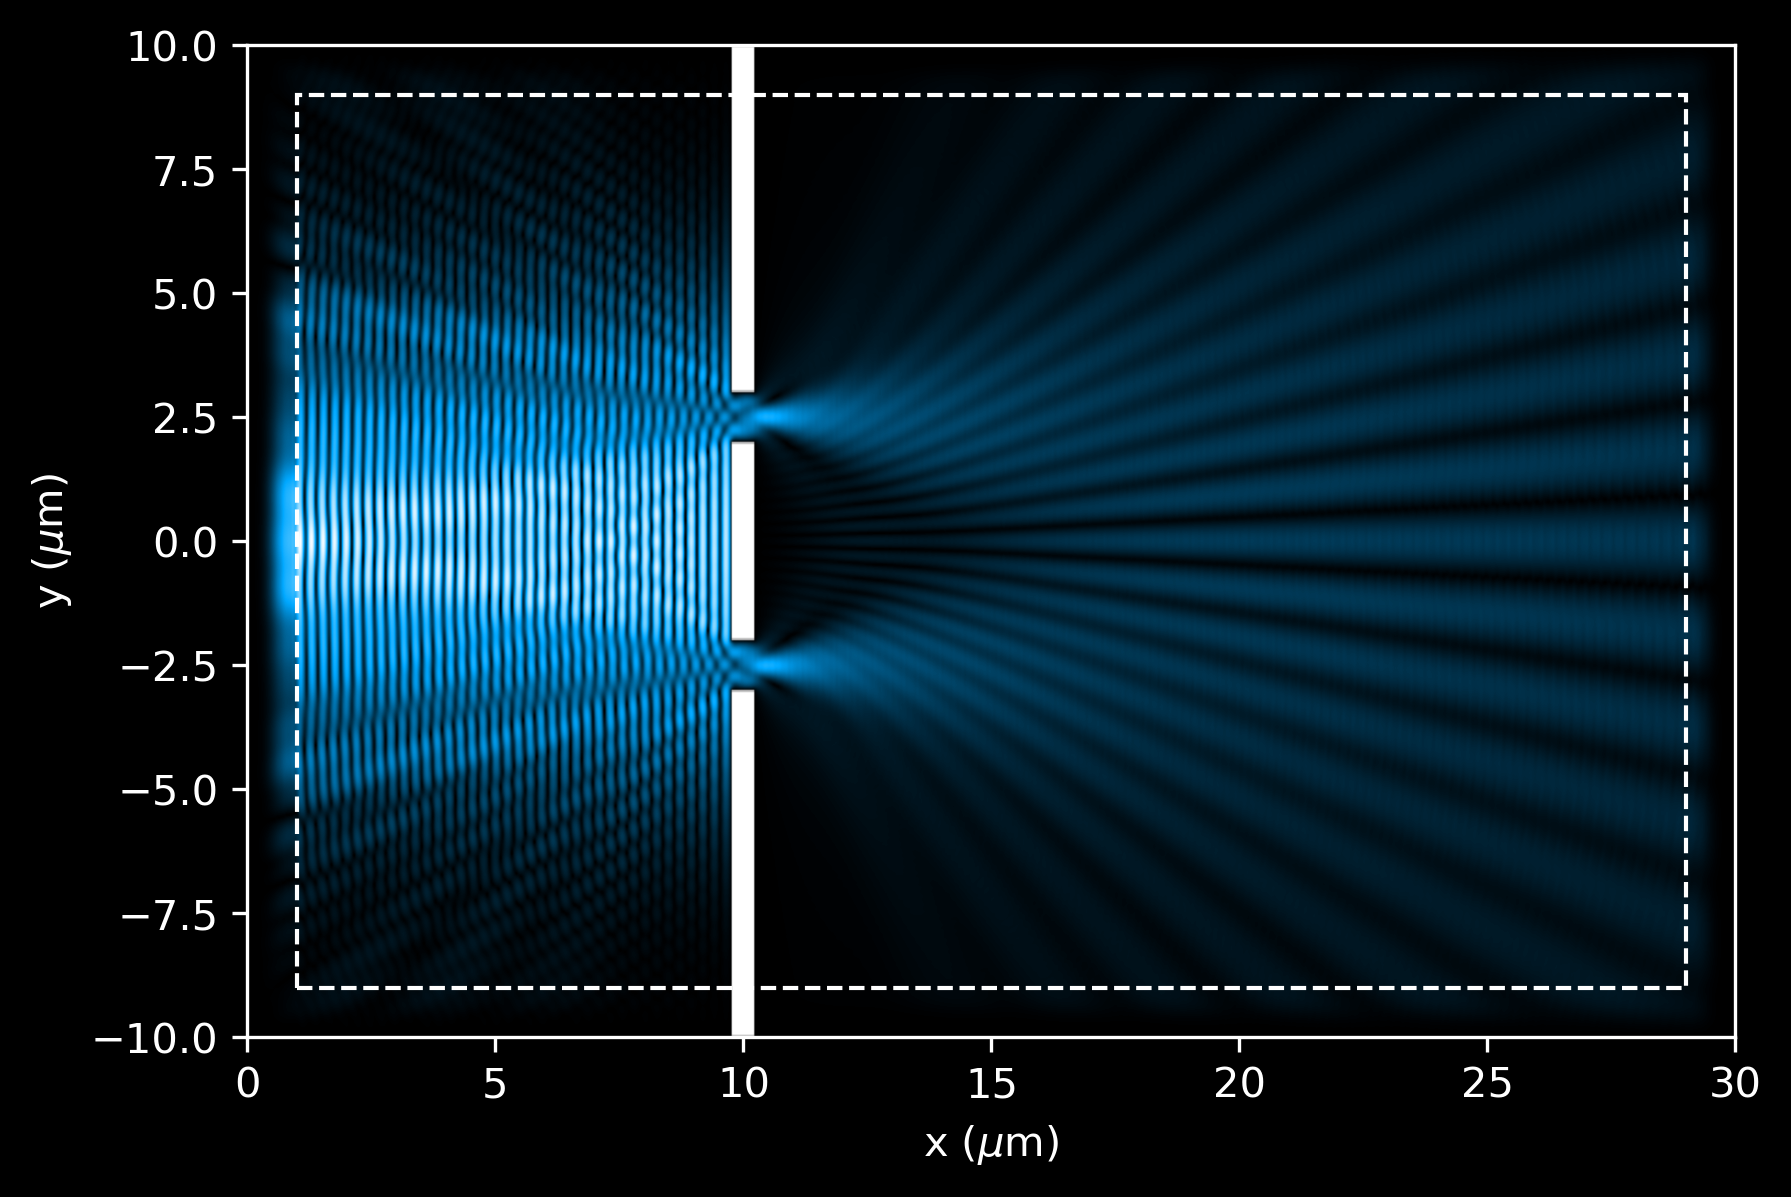

In [12]:
# Simulation object

sim = mp.Simulation(
    cell_size=cell_size,
    sources=[source],
    boundary_layers=pml_layers,
    geometry=geometry,
    resolution=resolution,
    force_complex_fields=True
)

# Method to extract Ez
def get_data(sim, cell_size):
    ez_data = sim.get_array(
        center = mp.Vector3(),
        size = cell_size,
        component = mp.Ez
    )
    eps_data = sim.get_array(
        center = mp.Vector3(),
        size = cell_size,
        component = mp.Dielectric
    )
    return ez_data, eps_data

# Run simulation
sim.run(until = cell_size[0] + 10)
ez_data, eps_data = get_data(sim, cell_size)

# Plot simulation
ax = plt.gca()
plot_ez_data(ez_data, domain, ax = ax)
plot_eps_data(eps_data, domain, ax = ax)
plot_pml(pml_thickness, domain, ax = ax)

In [13]:
# Sim duration
sim_time = 120
n_frames = 6

# Save path
sim_path = 'simulation.h5'

# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    sources = [source],
    boundary_layers= pml_layers,
    geometry=geometry,
    resolution=resolution,
    force_complex_fields=True
)

"""
def simulate(sim, sim_path, sim_time, n_frames):
    
    # Remove previous sim file
    if os.path.exists(sim_path):
        os.remove(sim_path)
        
    # Time delta (in fs) between snapshots.
    fs_delta = sim_time / (n_frames - 1)
    
    # Save data to HDF5 binary file
    with h5py.File(sim_path, 'a') as f:
        
        # Save simulation params for future reference
        f.attrs['sim_time'] = sim_time
        f.attrs['n_frames'] = n_frames
        f.attrs['fs_delta'] = fs_delta
        f.attrs['resolution'] = sim.resolution
        
        # Save initial state as first frame
        sim.init_sim()
        ez_data, eps_data = get_data(sim, cell_size)
        f.create_dataset(
            'ez_data',
            shape=(n_frames, *ez_data.shape),
            dtype=ez_data.dtype
        )
        f.create_dataset(
            'eps_data',
            shape=eps_data.shape,
            dtype=eps_data.dtype
        )
        f['ez_data'][0] = ez_data
        f['eps_data'][:] = eps_data
        
        # Simulate and capture snapshots
        
        for i in range(1, n_frames):
            
            # Run until next frame time
            sim.run(until = SOL*fs_delta)
        
            # Capture electrical field data
            ez_data, _ = get_data(sim, cell_size)
            f['ez_data'][i] = ez_data
            
simulate(sim, sim_path, sim_time, n_frames)

"""

"\ndef simulate(sim, sim_path, sim_time, n_frames):\n    \n    # Remove previous sim file\n    if os.path.exists(sim_path):\n        os.remove(sim_path)\n        \n    # Time delta (in fs) between snapshots.\n    fs_delta = sim_time / (n_frames - 1)\n    \n    # Save data to HDF5 binary file\n    with h5py.File(sim_path, 'a') as f:\n        \n        # Save simulation params for future reference\n        f.attrs['sim_time'] = sim_time\n        f.attrs['n_frames'] = n_frames\n        f.attrs['fs_delta'] = fs_delta\n        f.attrs['resolution'] = sim.resolution\n        \n        # Save initial state as first frame\n        sim.init_sim()\n        ez_data, eps_data = get_data(sim, cell_size)\n        f.create_dataset(\n            'ez_data',\n            shape=(n_frames, *ez_data.shape),\n            dtype=ez_data.dtype\n        )\n        f.create_dataset(\n            'eps_data',\n            shape=eps_data.shape,\n            dtype=eps_data.dtype\n        )\n        f['ez_data'][0] =

In [14]:
"""
fig_rows = 3
fig_cols = 2
n_subplots = fig_rows * fig_cols
fig, ax = plt.subplots(
    fig_rows,
    fig_cols,
    figsize = (9,12),
    sharex= False,
    sharey= True
)

with h5py.File(sim_path, 'r') as f:
    for k in range(n_subplots):
        i, j = int(k/fig_cols), (k%fig_cols)
        _ax = ax[i][j]
        ez_data = f['ez_data'][k]
        eps_data = f['eps_data'][:]
        elapsed = k * f.attrs['fs_delta']
        vmax = 0.6
        plot_ez_data(ez_data, domain, ax = _ax, vmax = vmax, elapsed = elapsed)
        plot_eps_data(eps_data, domain, ax = _ax)
        plot_pml(pml_thickness, domain, ax = _ax)
        
"""

"\nfig_rows = 3\nfig_cols = 2\nn_subplots = fig_rows * fig_cols\nfig, ax = plt.subplots(\n    fig_rows,\n    fig_cols,\n    figsize = (9,12),\n    sharex= False,\n    sharey= True\n)\n\nwith h5py.File(sim_path, 'r') as f:\n    for k in range(n_subplots):\n        i, j = int(k/fig_cols), (k%fig_cols)\n        _ax = ax[i][j]\n        ez_data = f['ez_data'][k]\n        eps_data = f['eps_data'][:]\n        elapsed = k * f.attrs['fs_delta']\n        vmax = 0.6\n        plot_ez_data(ez_data, domain, ax = _ax, vmax = vmax, elapsed = elapsed)\n        plot_eps_data(eps_data, domain, ax = _ax)\n        plot_pml(pml_thickness, domain, ax = _ax)\n        \n"

In [15]:
"""
with h5py.File(sim_path, 'r') as f:
    final_snap = f['ez_data'][-1]
    
# Compute intensity
final_snap = np.abs(final_snap)**2

# Pick slices at different distances
slice_dists = [10,11,12,15,20,25]
slices = [final_snap[i*resolution] for i in slice_dists]
yarr = np.linspace(domain[2], domain[3], final_snap.shape[1])

# Plotting function
def plot_intensity(slice, yarr, ax1, ax2, vmax = None, xval = None, xlabel = False, ylabel = False):
    ax1.plot(yarr, slice)
    ax1.tick_params(axis = 'x', labelbottom = False)
    
    if ylabel:
        ax1.set_ylabel('$|E|^2$')
    else:
        ax1.tick_params('y', labelleft = False)
    
    if xval:
        ax1.annotate(
            f'x={xval}',
            xy = (1,1),
            xytext = (-4,-4),
            xycoords = 'axes fraction',
            textcoords = 'offset pixels',
            horizontalalignment = 'right',
            verticalalignment = 'top'
        )
        
    ax2.imshow(
        np.vstack(slice).T,
        cmap = 'inferno',
        aspect = 'auto',
        vmax = vmax,
        extent = [yarr[0], yarr[-1], 0, 1]
    )
    ax2.set_xlim([yarr[0], yarr[-1]])
    ax2.tick_params('y', labelleft = False)
    ax2.set_yticks([])
    if xlabel:
        ax2.set_xlabel('y ($\mu$m)')
    else:
        ax2.tick_params(axis = 'x', labelbottom = False)
        
fig, ax = plt.subplots(
    4,3,
    figsize = (9,6),
    gridspec_kw=dict(
        width_ratios = (4,4,4),
        height_ratios = (4, 1, 4, 1),
        wspace = 0.12,
        hspace = 0.1
    ),
    sharex = 'col',
    sharey = 'row',
)

for k, slice in enumerate(slices):
    i = 2 * int(k/3)
    j = k%3
    plot_intensity(
        slice, yarr, ax[i][j], ax[i+1][j],
        vmax = np.max(slices[:3]) if k<3 else np.max(slices[3:]),
        xval = slice_dists[k],
        xlabel = (i==2),
        ylabel = (j==0)
    )

"""


"\nwith h5py.File(sim_path, 'r') as f:\n    final_snap = f['ez_data'][-1]\n    \n# Compute intensity\nfinal_snap = np.abs(final_snap)**2\n\n# Pick slices at different distances\nslice_dists = [10,11,12,15,20,25]\nslices = [final_snap[i*resolution] for i in slice_dists]\nyarr = np.linspace(domain[2], domain[3], final_snap.shape[1])\n\n# Plotting function\ndef plot_intensity(slice, yarr, ax1, ax2, vmax = None, xval = None, xlabel = False, ylabel = False):\n    ax1.plot(yarr, slice)\n    ax1.tick_params(axis = 'x', labelbottom = False)\n    \n    if ylabel:\n        ax1.set_ylabel('$|E|^2$')\n    else:\n        ax1.tick_params('y', labelleft = False)\n    \n    if xval:\n        ax1.annotate(\n            f'x={xval}',\n            xy = (1,1),\n            xytext = (-4,-4),\n            xycoords = 'axes fraction',\n            textcoords = 'offset pixels',\n            horizontalalignment = 'right',\n            verticalalignment = 'top'\n        )\n        \n    ax2.imshow(\n        np.vs

<function matplotlib.pyplot.close(fig: "None | int | str | Figure | Literal['all']" = None) -> 'None'>

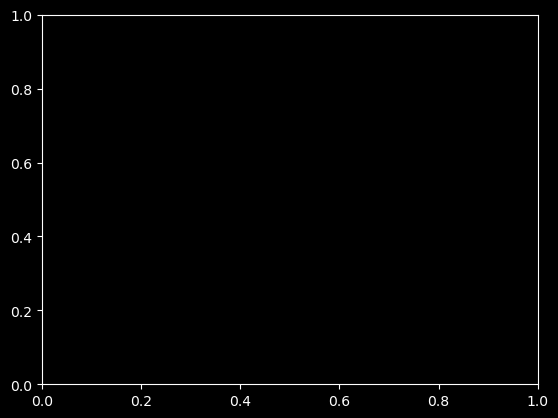

In [16]:
sim.reset_meep()
f = plt.figure(dpi = 100)
Animate = mp.Animate2D(fields = mp.Ez, f=f, realtime = False, normalize = True)
plt.close

In [17]:
%config Application.log_level="DEBUG"
%config ZMQInteractiveShell.pdb = True
%config InteractiveShell.ast_node_interactivity = 'all'
%config IPCompleter.greedy = True

%config IPCompleter.use_jedi = True
%config IPCompleter.greedy = True
%config IPCompleter.merge_completions = True

%config Completer.use_jedi = True
%config Completer.greedy = True
%config Completer.merge_completions = True

[IPKernelApp] {'header': {'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_170', 'msg_type': 'execute_reply', 'username': 'lakubis', 'session': '0584b50d-9cfffcd9e74a71f03551b6e2', 'date': datetime.datetime(2024, 1, 20, 23, 40, 5, 554554, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_170', 'msg_type': 'execute_reply', 'parent_header': {'date': datetime.datetime(2024, 1, 20, 23, 40, 5, 454000, tzinfo=tzutc()), 'msg_id': '3d3afb05-75dd-429f-8a76-a665cb1db4eb', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'content': {'status': 'ok', 'execution_count': 17, 'user_expressions': {}, 'payload': []}, 'metadata': {'started': datetime.datetime(2024, 1, 20, 23, 40, 5, 495617, tzinfo=datetime.timezone.utc), 'dependencies_met': True, 'engine': '92b0c2af-da1c-4dc9-8e38-0ca926cdf4bb', 'status': 'ok'}, 'tracker': <zmq.sugar.tracker.MessageTra

In [18]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

[IPKernelApp] 
*** MESSAGE TYPE:execute_request***
[IPKernelApp]    Content: {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': "import os\nos.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'"}
   --->
   
[IPKernelApp] execute_request: {'header': {'date': datetime.datetime(2024, 1, 20, 23, 40, 5, 568000, tzinfo=tzutc()), 'msg_id': '3b21da85-e9f3-4034-84e2-0f487b3024cc', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'msg_id': '3b21da85-e9f3-4034-84e2-0f487b3024cc', 'msg_type': 'execute_request', 'parent_header': {}, 'metadata': {'cellId': 'vscode-notebook-cell://wsl%2Bubuntu/home/lakubis/meep_stuff/Double_slit.ipynb#X30sdnNjb2RlLXJlbW90ZQ%3D%3D'}, 'content': {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': "import os\nos.environ['PYDEVD_DISABLE_FIL

In [19]:
sim.run(mp.at_every(0.4,Animate), until = 30)
plt.close()

[IPKernelApp] 
*** MESSAGE TYPE:execute_request***
[IPKernelApp]    Content: {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': 'sim.run(mp.at_every(0.4,Animate), until = 30)\nplt.close()'}
   --->
   
[IPKernelApp] execute_request: {'header': {'date': datetime.datetime(2024, 1, 20, 23, 40, 5, 683000, tzinfo=tzutc()), 'msg_id': '3be60c9b-2874-4f92-a657-ebe08bc07b05', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'msg_id': '3be60c9b-2874-4f92-a657-ebe08bc07b05', 'msg_type': 'execute_request', 'parent_header': {}, 'metadata': {'cellId': 'vscode-notebook-cell://wsl%2Bubuntu/home/lakubis/meep_stuff/Double_slit.ipynb#X22sdnNjb2RlLXJlbW90ZQ%3D%3D'}, 'content': {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': 'sim.run(mp.at_every(0.4,Animate), until = 30

-----------
Initializing structure...
time for choose_chunkdivision = 0.000447035 s
Working in 2D dimensions.
Computational cell is 30 x 20 x 0 with resolution 22
     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
time for set_epsilon = 0.561841 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=30.0)

     block, center = (-5,6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,-6.5,0)
          size (0.5,7,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
     block, center = (-5,0,0)
          size (0.5,4,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1e+06,1e+06,1e+06)
Meep progress: 6.7272727272727275/30.0 = 22.4% done in 4.0s, 13.9s to go
on time step 297 (time=6.75), 0.0135184 s/step
Meep progress: 13.590909090909092/30.0 = 45.3% done in 8.0s, 9.7s to go
on time step 601 (time=13.6591), 0.0131836 s/step
Meep progress: 24.522727272727273/30.0 = 81.7% done in 12.0s, 2.7s to go
on time step 1080 (time=24.5455), 0.00835555 s/step
Normalizing field data...
run 0 finished at t = 30.0 (1320 timesteps)


[IPKernelApp] {'header': {'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_245', 'msg_type': 'execute_reply', 'username': 'lakubis', 'session': '0584b50d-9cfffcd9e74a71f03551b6e2', 'date': datetime.datetime(2024, 1, 20, 23, 41, 37, 122073, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_245', 'msg_type': 'execute_reply', 'parent_header': {'date': datetime.datetime(2024, 1, 20, 23, 40, 5, 683000, tzinfo=tzutc()), 'msg_id': '3be60c9b-2874-4f92-a657-ebe08bc07b05', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'content': {'status': 'ok', 'execution_count': 19, 'user_expressions': {}, 'payload': []}, 'metadata': {'started': datetime.datetime(2024, 1, 20, 23, 40, 5, 762372, tzinfo=datetime.timezone.utc), 'dependencies_met': True, 'engine': '92b0c2af-da1c-4dc9-8e38-0ca926cdf4bb', 'status': 'ok'}, 'tracker': <zmq.sugar.tracker.MessageTr

In [20]:
import sys
import errno
filename = 'dual_slit.mp4'
try:
    Animate.to_mp4(10, filename)
except IOError as e:
    if e.errno == errno.EPIPE:
        pass

[IPKernelApp] 
*** MESSAGE TYPE:execute_request***
[IPKernelApp]    Content: {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': "import sys\nimport errno\nfilename = 'dual_slit.mp4'\ntry:\n    Animate.to_mp4(10, filename)\nexcept IOError as e:\n    if e.errno == errno.EPIPE:\n        pass"}
   --->
   
[IPKernelApp] execute_request: {'header': {'date': datetime.datetime(2024, 1, 20, 23, 41, 37, 133000, tzinfo=tzutc()), 'msg_id': '719ba151-eed2-431d-a3e4-11dfabcb18e5', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'msg_id': '719ba151-eed2-431d-a3e4-11dfabcb18e5', 'msg_type': 'execute_request', 'parent_header': {}, 'metadata': {'cellId': 'vscode-notebook-cell://wsl%2Bubuntu/home/lakubis/meep_stuff/Double_slit.ipynb#X23sdnNjb2RlLXJlbW90ZQ%3D%3D'}, 'content': {'silent': False, 'store_history': True, 'user_expressions':

Generating MP4...


[IPKernelApp] {'header': {'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_254', 'msg_type': 'execute_reply', 'username': 'lakubis', 'session': '0584b50d-9cfffcd9e74a71f03551b6e2', 'date': datetime.datetime(2024, 1, 20, 23, 41, 42, 282696, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_254', 'msg_type': 'execute_reply', 'parent_header': {'date': datetime.datetime(2024, 1, 20, 23, 41, 37, 133000, tzinfo=tzutc()), 'msg_id': '719ba151-eed2-431d-a3e4-11dfabcb18e5', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'content': {'status': 'ok', 'execution_count': 20, 'user_expressions': {}, 'payload': []}, 'metadata': {'started': datetime.datetime(2024, 1, 20, 23, 41, 37, 194459, tzinfo=datetime.timezone.utc), 'dependencies_met': True, 'engine': '92b0c2af-da1c-4dc9-8e38-0ca926cdf4bb', 'status': 'ok'}, 'tracker': <zmq.sugar.tracker.Message

In [21]:
from IPython.display import Video

Video(filename)

[IPKernelApp] 
*** MESSAGE TYPE:execute_request***
[IPKernelApp]    Content: {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': 'from IPython.display import Video\n\nVideo(filename)'}
   --->
   
[IPKernelApp] execute_request: {'header': {'date': datetime.datetime(2024, 1, 20, 23, 41, 42, 296000, tzinfo=tzutc()), 'msg_id': '7ab69346-d769-423f-a274-768f902c6340', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'msg_id': '7ab69346-d769-423f-a274-768f902c6340', 'msg_type': 'execute_request', 'parent_header': {}, 'metadata': {'cellId': 'vscode-notebook-cell://wsl%2Bubuntu/home/lakubis/meep_stuff/Double_slit.ipynb#X24sdnNjb2RlLXJlbW90ZQ%3D%3D'}, 'content': {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': 'from IPython.display import Video\n\nVideo(filena

[IPKernelApp] {'header': {'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_263', 'msg_type': 'execute_reply', 'username': 'lakubis', 'session': '0584b50d-9cfffcd9e74a71f03551b6e2', 'date': datetime.datetime(2024, 1, 20, 23, 41, 42, 365082, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '0584b50d-9cfffcd9e74a71f03551b6e2_5693_263', 'msg_type': 'execute_reply', 'parent_header': {'date': datetime.datetime(2024, 1, 20, 23, 41, 42, 296000, tzinfo=tzutc()), 'msg_id': '7ab69346-d769-423f-a274-768f902c6340', 'msg_type': 'execute_request', 'session': '60aed866-9825-4b91-8a4f-3924d8d4cfe7', 'username': '182f1bbf-6cc3-47c5-8443-a7a1e6f78f0b', 'version': '5.2'}, 'content': {'status': 'ok', 'execution_count': 21, 'user_expressions': {}, 'payload': []}, 'metadata': {'started': datetime.datetime(2024, 1, 20, 23, 41, 42, 350937, tzinfo=datetime.timezone.utc), 'dependencies_met': True, 'engine': '92b0c2af-da1c-4dc9-8e38-0ca926cdf4bb', 'status': 'ok'}, 'tracker': <zmq.sugar.tracker.Message